In [49]:
from orphics import sehgal, maps
import healpy as hp
from pixell import utils, enmap, curvedsky, enplot, wcsutils
import os
import numpy as np
import matplotlib.pyplot as plt
import lmdb
from cosmikyu import datasets, transforms

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sehgal_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/inputs/microwaveSky"
SEHGAL10 = sehgal.SehgalSky2010(path=sehgal_dir, data_type='alm')
rfs = {"kappa": lambda : SEHGAL10.get_kappa(),
       "ksz": lambda : SEHGAL10.get_ksz(148),
       "tsz": lambda :SEHGAL10.get_tsz(148),
       "rad_pts": lambda :SEHGAL10.get_radio(148),
       "ir_pts": lambda :SEHGAL10.get_cib(148)
      }
lmax = 8000
shape, wcs = enmap.fullsky_geometry(res=0.5*utils.arcmin)


output_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/rotated_scaled"
def output_path(x):
    return os.path.join(output_dir, x)

test = {}
rot_angles1 = [0, 15, 30, 45, 60, 75]
rot_angles2 = [0, 20, 40, 60, 80]
for compt_idx in ["kappa"]:
    continue
    print(compt_idx)
    alm_ref = np.complex128(rfs[compt_idx]())
    for rot_angle1 in rot_angles1:
        for rot_angle2 in rot_angles2:
            file_path = output_path("%s_{}_%s_%s_000.fits")
            file_path = file_path %(compt_idx, "%0.3d"%rot_angle1, "%0.3d"%rot_angle2)
            print(file_path)
            alm_path = file_path.format("alm")
            enmap_path = file_path.format("enmap")
            if not os.path.exists(alm_path):
                print("rotating")
                alm = alm_ref.copy()
                if rot_angle2 != 0:
                    hp.rotate_alm(alm, rot_angle1*utils.degree, rot_angle2*utils.degree, 0, lmax=lmax)
                elif rot_angle2 == 0 and rot_angle1 != 0:
                    continue
                else:
                    pass
                hp.fitsfunc.write_alm(alm_path, alm, overwrite=True)
            else:
                alm = hp.read_alm(alm_path, hdu=(1))
            alm = np.complex128(alm)

            if not os.path.exists(enmap_path) and False:
                print("alm2map")
                emap = curvedsky.alm2map(alm, enmap.zeros(shape, wcs))
                enmap.write_fits(enmap_path, emap)
                del emap

            del alm


for compt_idx in ["ksz", "tsz", "ir_pts", "rad_pts"]:
    continue
    print(compt_idx)
    alm_ref = np.complex128(rfs[compt_idx]())
    for rot_angle1 in rot_angles1:
        for rot_angle2 in rot_angles2:
            file_path = output_path("148_%s_{}_%s_%s_000.fits")
            file_path = file_path %(compt_idx, "%0.3d"%rot_angle1, "%0.3d"%rot_angle2)
            print(file_path)
            alm_path = file_path.format("alm")
            enmap_path = file_path.format("enmap")
            if not os.path.exists(alm_path):
                print("rotating")
                alm = alm_ref.copy()
                if rot_angle2 != 0:
                    hp.rotate_alm(alm, rot_angle1*utils.degree, rot_angle2*utils.degree, 0, lmax=lmax)
                elif rot_angle2 == 0 and rot_angle1 != 0:
                    continue
                else:
                    pass
                hp.fitsfunc.write_alm(alm_path, alm, overwrite=True)
            else:
                alm = hp.read_alm(alm_path, hdu=(1))
            alm = np.complex128(alm)

            if not os.path.exists(enmap_path) and False:
                print("alm2map")
                emap = curvedsky.alm2map(alm, enmap.zeros(shape, wcs))

                enmap.write_fits(enmap_path, emap)
                del emap

            del alm


In [3]:
compts = ["kappa", "ksz", "tsz", "ir_pts", "rad_pts"]

shape, wcs = enmap.fullsky_geometry(res=0.5*utils.arcmin)
ycent = shape[0] // 2
ydelta = int(10*utils.degree/(0.5*utils.arcmin))
ymin, ymax = ycent-ydelta, ycent+ydelta
print(shape, ycent, ydelta, ymin, ymax)

template = enmap.zeros(shape, wcs)
template = template[ymin:ymax,:].copy()
nshape, nwcs = template.shape, template.wcs
nshape = (len(compts),) + nshape
print(nshape, nwcs)


(21601, 43200) 10800 1200 9600 12000
(5, 2400, 43200) car:{cdelt:[-0.008333,0.008333],crval:[0.004167,0],crpix:[2.16e+04,1201]}


In [4]:
rot_angles1 = [0, 15, 30, 45, 60, 75]
rot_angles2 = [0, 20, 40, 60, 80]

TRAIN_SET = 0
TEST_SET = 1
MODEL_SELEC_SET = 2

input_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/rotated_scaled"
def input_path(rot_angle1, rot_angle2, compt_idx):
    freq_idx = "" if compt_idx == "kappa" else "148_"
    file_name = "%s%s_alm_%s_%s_000.fits" %(freq_idx, compt_idx, "%0.3d"%rot_angle1, "%0.3d"%rot_angle2)
    return os.path.join(input_dir, file_name)

output_dir = "/home/dwhan89/workspace/cosmikyu/data/sehgal"
def output_path(x):
    return os.path.join(output_dir, x)

def get_input_map(rot_angle1, rot_angle2, nshape, nwcs, compts=compts):
    ishape = nshape[-2:]
    ret = enmap.zeros(nshape, nwcs)
    for i, compt_idx in enumerate(compts):
        input_file = input_path(rot_angle1, rot_angle2, compt_idx)
        print("loading", input_file)
        alm = np.complex128(hp.read_alm(input_file, hdu=(1)))
        ret[i,...] = curvedsky.alm2map(alm, enmap.zeros(ishape, nwcs))
        del alm
    return ret

def get_random_seed(euler_angle, set_idx, sim_idx):
    return tuple(euler_angle) + (set_idx, sim_idx)

nset = 25
ntrain = 200*1000
ntest = 30*1000
nmodel = 30*1000
overwrite = False

stamp_byte = np.zeros((len(compts),128,128), dtype=np.float64).nbytes
def taskrange(nsample, set_idx, size):
   
    ntask = nsample
    subrange = None

    if size > ntask:
        delta     = 1
        remainder = 0
    else:
        delta     = ntask//size
        remainder = ntask%size

    # correction for remainder 
    start      = set_idx*delta
    scorr      = min(set_idx, remainder)
    start      += scorr

    delta      += 1 if set_idx < remainder else 0


    end        = start + delta
    end        = min(end, ntask)
    subrange   = np.arange(start, end)
    return subrange

def get_next_pixpos(seed, shape,  stamp_width_pix=128):
    np.random.seed(seed)
    yfrom = np.random.randint(0, shape[-2]-stamp_width_pix)
    xfrom = np.random.randint(0, shape[-1]-stamp_width_pix)
    yto = yfrom + stamp_width_pix
    xto = xfrom + stamp_width_pix
    return (yfrom, xfrom, yto, xto)
    
train_db = output_path("sehgal_train")
if not os.path.exists(train_db) or overwrite:
    map_size = stamp_byte*ntrain*10
    DB = lmdb.open(train_db, map_size=map_size)
    with DB.begin(write=True) as txn:
        ctr = 0
        for rot_angle1 in rot_angles1:
            for rot_angle2 in rot_angles2:
                if rot_angle1 != 0 and rot_angle2 == 0: continue
                print("set idx", ctr, rot_angle1, rot_angle2, 0)
                input_map = get_input_map(rot_angle1, rot_angle2, nshape, nwcs)

                subrange = taskrange(ntrain, ctr, nset)
                if len(subrange) > 0:  print("cut train set", subrange[0], subrange[-1])
                for i in subrange:
                    seed = get_random_seed((rot_angle1, rot_angle2, 0), TRAIN_SET, i)
                    yfrom, xfrom, yto, xto = get_next_pixpos(seed, nshape)
                    stamp = np.array(input_map[...,yfrom:yto,xfrom:xto])
                    str_idx = '{:08}'.format(i)
                    txn.put(str_idx.encode('ascii'), stamp.tobytes())
                    del stamp
                
                ctr += 1
                
                del input_map

test_db = output_path("sehgal_test")
if not os.path.exists(test_db) or overwrite:
    map_size = stamp_byte*ntest*10
    DB = lmdb.open(test_db, map_size=map_size)
    with DB.begin(write=True) as txn:
        ctr = 0
        for rot_angle1 in rot_angles1:
            for rot_angle2 in rot_angles2:
                if rot_angle1 != 0 and rot_angle2 == 0: continue
                print("set idx", ctr, rot_angle1, rot_angle2, 0)
                input_map = get_input_map(rot_angle1, rot_angle2, nshape, nwcs)

                subrange = taskrange(ntest, ctr, nset)
                if len(subrange) > 0:  print("cut test set", subrange[0], subrange[-1])
                for i in subrange:
                    seed = get_random_seed((rot_angle1, rot_angle2, 0), TEST_SET, i)
                    yfrom, xfrom, yto, xto = get_next_pixpos(seed, nshape)
                    stamp = np.array(input_map[...,yfrom:yto,xfrom:xto])
                    str_idx = '{:08}'.format(i)
                    txn.put(str_idx.encode('ascii'), stamp.tobytes())
                    del stamp
                
                ctr += 1
                
                del input_map

model_db = output_path("sehgal_model")
if not os.path.exists(model_db) or overwrite:
    map_size = stamp_byte*nmodel*10
    DB = lmdb.open(model_db, map_size=map_size)
    with DB.begin(write=True) as txn:
        ctr = 0
        for rot_angle1 in rot_angles1:
            for rot_angle2 in rot_angles2:
                if rot_angle1 != 0 and rot_angle2 == 0: continue
                print("set idx", ctr, rot_angle1, rot_angle2, 0)
                input_map = get_input_map(rot_angle1, rot_angle2, nshape, nwcs)

                subrange = taskrange(nmodel, ctr, nset)
                if len(subrange) > 0:  print("cut model set", subrange[0], subrange[-1])
                for i in subrange:
                    seed = get_random_seed((rot_angle1, rot_angle2, 0), MODEL_SELEC_SET, i)
                    yfrom, xfrom, yto, xto = get_next_pixpos(seed, nshape)
                    stamp = np.array(input_map[...,yfrom:yto,xfrom:xto])
                    str_idx = '{:08}'.format(i)
                    txn.put(str_idx.encode('ascii'), stamp.tobytes())
                    del stamp
                
                ctr += 1
                
                del input_map
                #print(yfrom, xfrom, yto, xto)

            
            
                  
 

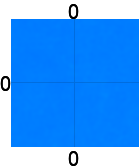

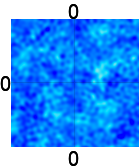

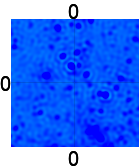

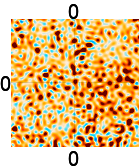

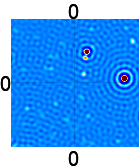

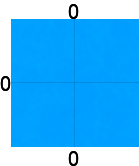

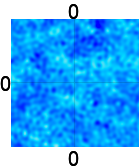

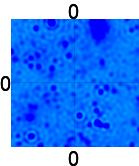

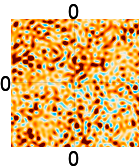

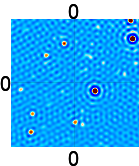

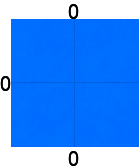

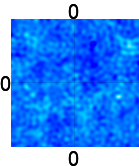

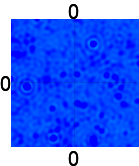

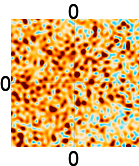

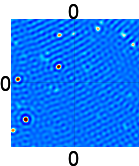

In [5]:
_, wcs = maps.rect_geometry(width_arcmin=64., px_res_arcmin=0.5)
nplot = 1

SDS_train = datasets.SehgalDataSet(output_dir, data_type="train")
for i in range(nplot):
    emap = enmap.enmap(SDS_train[i], wcs=wcs)
    enplot.pshow(emap)
    
SDS_test = datasets.SehgalDataSet(output_dir, data_type="test")
for i in range(nplot):
    emap = enmap.enmap(SDS_test[i], wcs=wcs)
    enplot.pshow(emap)
    
SDS_model = datasets.SehgalDataSet(output_dir, data_type="model")
for i in range(nplot):
    emap = enmap.enmap(SDS_model[i], wcs=wcs)
    enplot.pshow(emap)

{'kappa': {'mean': -0.0004478542447624235, 'std': 0.07778973898009228, 'z_fact': 2, 'pow_pos': 1, 'pow_neg': 1}, 'ir_pts': {'mean': 4.012027995481708, 'std': 1.045217718969116, 'z_fact': 2, 'pow_pos': 0.5, 'pow_neg': 1}, 'ksz': {'mean': -0.00072172095629033, 'std': 2.272005951615463, 'z_fact': 2, 'pow_pos': 1, 'pow_neg': 1}, 'rad_pts': {'mean': 0.17263686467077005, 'std': 3.461675026537242, 'z_fact': 2, 'pow_pos': 0.7, 'pow_neg': 0.7}, 'tsz': {'mean': -1.3253027796247203, 'std': 0.19984606861267054, 'z_fact': 2, 'pow_pos': 1, 'pow_neg': 0.25}}
5.126678385873015 -2.987963427257657


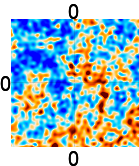

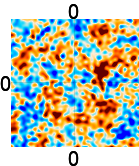

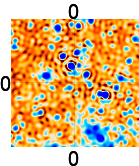

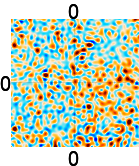

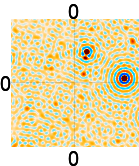

In [105]:
norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/normalization_info.npz"
SDN = transforms.SehgalDataNormalizer(norm_info_file, z_normalize=True)
SDUN = transforms.SehgalDataUnnormalizer(norm_info_file, z_normalize=True)
print(SDN.norm_info)

_, wcs = maps.rect_geometry(width_arcmin=64., px_res_arcmin=0.5)
nplot = 1

SDS_train = datasets.SehgalDataSet(output_dir, data_type="train")
for i in range(nplot):
    emap = enmap.enmap(SDN(SDS_train[i]), wcs=wcs)
    print(emap.max(), emap.min())
    enplot.pshow(emap)
    

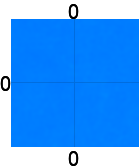

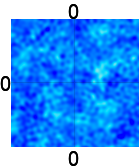

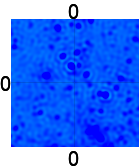

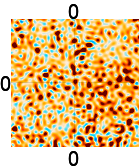

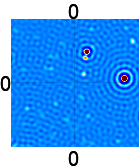

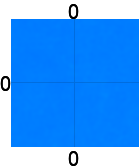

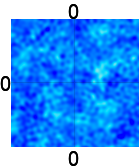

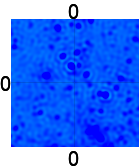

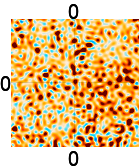

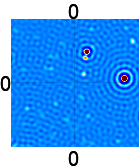

In [104]:
norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/normalization_info.npz"
SDN = transforms.SehgalDataNormalizer(norm_info_file, z_normalize=True)
SDUN = transforms.SehgalDataUnnormalizer(norm_info_file, z_normalize=True)

_, wcs = maps.rect_geometry(width_arcmin=64., px_res_arcmin=0.5)
nplot = 1

SDS_train = datasets.SehgalDataSet(output_dir, data_type="train")
for i in range(nplot):
    ref = SDS_train[i].copy()
    processed = SDUN(SDN(SDS_train[i].copy()))
    emap = enmap.enmap(ref, wcs=wcs)
    enplot.pshow(emap)
    emap = enmap.enmap(processed, wcs=wcs)
    enplot.pshow(emap)   

1.0000000000000229
0.9999999999999998


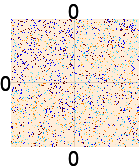

1.0000000000000002
0.9999999999999998


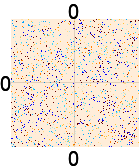

1.000000000000001
0.9999999999999992


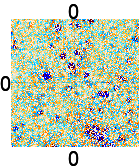

1.0000000000000007
0.9999999999999991


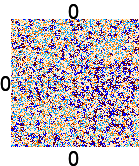

1.0000000000000078
0.9999999999999956


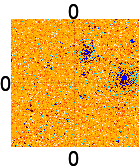

In [108]:
norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/normalization_info.npz"
SDN = transforms.SehgalDataNormalizer(norm_info_file, z_normalize=True)
SDUN = transforms.SehgalDataUnnormalizer(norm_info_file, z_normalize=True)

_, wcs = maps.rect_geometry(width_arcmin=64., px_res_arcmin=0.5)
nplot = 1

SDS_train = datasets.SehgalDataSet(output_dir, data_type="train")
for i in range(nplot):
    for j in range(5):
        ref = SDS_train[i].copy()
        processed = SDUN(SDN(SDS_train[i].copy()))
        ref = ref[j]
        processed = processed[j]
        emap = enmap.enmap(processed-ref, wcs=wcs)
        print(np.max(np.abs(np.nan_to_num(processed/ref))))
        print(np.min(np.abs(np.nan_to_num(processed/ref))))
        enplot.pshow(emap)
    
